### Lab 2 Research Question

The research question is can we predict which three zip codes provide the best investment
opportunity for the Syracuse Real Estate Investment Trust (SREIT)?

### Import

In [2]:
!pip install zipcodes
import numpy as np
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import zipcodes
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

### Read in data

In [3]:
# Import the zillow data
zillow_df = pd.read_csv('Zip_zhvi_uc_sfr_month.csv')

# convert non-timeseries
zillow_df[['City', 'State', 'Metro', 'CountyName']] = zillow_df[['City', 'State', 'Metro', 'CountyName']].astype(str)
zillow_df[['RegionID', 'RegionName', 'SizeRank']] = zillow_df[['RegionID', 'RegionName', 'SizeRank']].astype(int)

# convert to lowercase
zillow_df[['City', 'State', 'Metro', 'CountyName']] = zillow_df[['City', 'State', 'Metro', 'CountyName']].apply(lambda x: x.astype(str).str.lower().map(lambda x: x.strip()))
zillow_df['RegionName'] = zillow_df['RegionName'].astype('str').apply(lambda x: x.zfill(5))


### Examine the data

In [4]:
zillow_df.shape

(29148, 341)

In [5]:
date_columns = zillow_df.columns[9:]

# Extract and format the year and month in the "YYYY-MM" format for column names
formatted_column_names = date_columns.str.slice(0, 7)

# Rename the columns with the formatted names
zillow_df.columns = zillow_df.columns[:9].tolist() + formatted_column_names.tolist()

In [6]:
date_columns = zillow_df.columns[9:]

# Define the date range to keep (from 1997-01 to 2017-12)
start_date = '1997-01'
end_date = '2017-12'

# Filter and keep only the date columns within the specified range
filtered_date_columns = [col for col in date_columns if start_date <= col <= end_date]

# Select the columns to keep (including non-date columns)
columns_to_keep = zillow_df.columns[:9].tolist() + filtered_date_columns

# Create a new DataFrame with only the selected columns
filtered_df = zillow_df[columns_to_keep]


In [7]:
filtered_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1997-01,...,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
0,91982,1,77494,zip,TX,tx,katy,"houston-the woodlands-sugar land, tx",fort bend county,180715.917877,...,332680.115296,335709.575946,337400.117579,338669.424322,339702.688759,339727.221576,338324.366192,337767.450148,336210.189381,335704.482543
1,61148,2,08701,zip,NJ,nj,lakewood,"new york-newark-jersey city, ny-nj-pa",ocean county,144454.103134,...,400082.240603,402225.115243,405177.558402,414344.757851,421070.279042,424240.820038,426646.606015,423368.470919,421823.151107,420466.522192
2,91940,3,77449,zip,TX,tx,katy,"houston-the woodlands-sugar land, tx",harris county,100335.220243,...,172505.006251,173899.371552,174800.176601,175965.272885,176431.359905,176889.652403,177010.523603,177211.781533,177480.287360,177884.460706
3,62080,4,11368,zip,NY,ny,new york,"new york-newark-jersey city, ny-nj-pa",queens county,207108.680054,...,691731.518670,699742.695874,702621.621001,712762.951869,718054.658982,722519.563171,729285.791985,734435.973842,733641.305155,737776.277696
4,91733,5,77084,zip,TX,tx,houston,"houston-the woodlands-sugar land, tx",harris county,94870.057760,...,171253.601292,173106.773479,174201.118637,175283.040276,175889.593867,176117.782614,176147.814495,176078.011921,175505.069061,174963.236576


In [8]:
column_list = filtered_df.columns.tolist()

# The 'column_list' variable now contains a list of all the columns in the DataFrame 'df'
print(column_list)

['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName', '1997-01', '1997-02', '1997-03', '1997-04', '1997-05', '1997-06', '1997-07', '1997-08', '1997-09', '1997-10', '1997-11', '1997-12', '1998-01', '1998-02', '1998-03', '1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09', '1998-10', '1998-11', '1998-12', '1999-01', '1999-02', '1999-03', '1999-04', '1999-05', '1999-06', '1999-07', '1999-08', '1999-09', '1999-10', '1999-11', '1999-12', '2000-01', '2000-02', '2000-03', '2000-04', '2000-05', '2000-06', '2000-07', '2000-08', '2000-09', '2000-10', '2000-11', '2000-12', '2001-01', '2001-02', '2001-03', '2001-04', '2001-05', '2001-06', '2001-07', '2001-08', '2001-09', '2001-10', '2001-11', '2001-12', '2002-01', '2002-02', '2002-03', '2002-04', '2002-05', '2002-06', '2002-07', '2002-08', '2002-09', '2002-10', '2002-11', '2002-12', '2003-01', '2003-02', '2003-03', '2003-04', '2003-05', '2003-06', '2003-07', '2003-08', '2003-09', '20

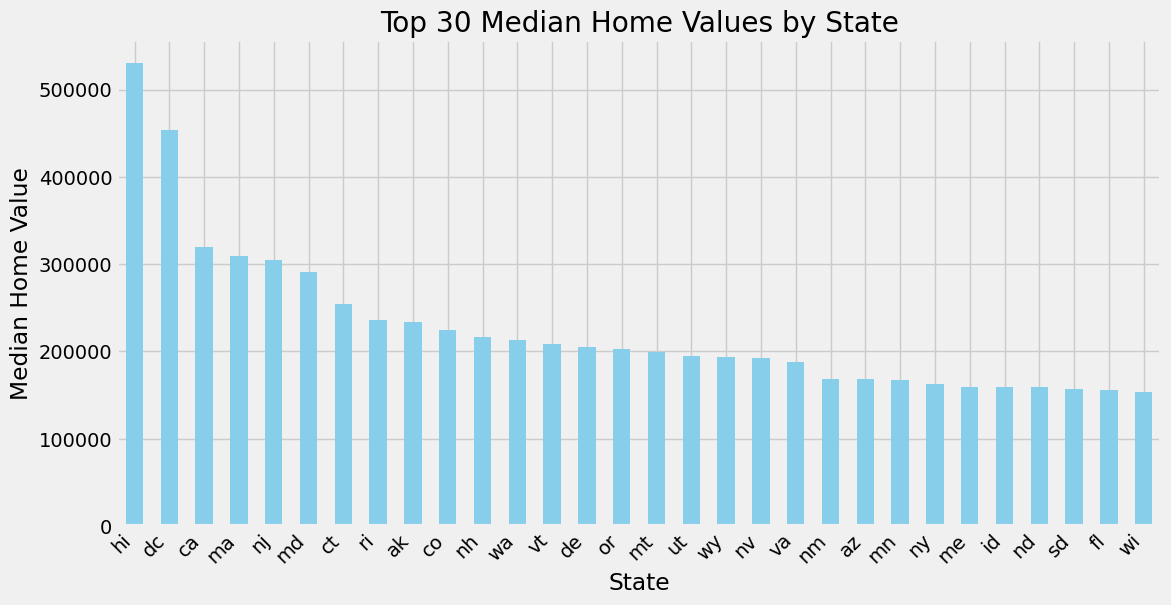

In [9]:
## Plot the median home values by state

import matplotlib.pyplot as plt



# Clean the data (remove unnecessary columns)
data = filtered_df[['State', '1997-01', '1997-02', '1997-03', '1997-04', '1997-05', '1997-06', '1997-07', '1997-08', '1997-09', '1997-10', '1997-11', '1997-12', '1998-01', '1998-02', '1998-03', '1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09', '1998-10', '1998-11', '1998-12', '1999-01', '1999-02', '1999-03', '1999-04', '1999-05', '1999-06', '1999-07', '1999-08', '1999-09', '1999-10', '1999-11', '1999-12', '2000-01', '2000-02', '2000-03', '2000-04', '2000-05', '2000-06', '2000-07', '2000-08', '2000-09', '2000-10', '2000-11', '2000-12', '2001-01', '2001-02', '2001-03', '2001-04', '2001-05', '2001-06', '2001-07', '2001-08', '2001-09', '2001-10', '2001-11', '2001-12', '2002-01', '2002-02', '2002-03', '2002-04', '2002-05', '2002-06', '2002-07', '2002-08', '2002-09', '2002-10', '2002-11', '2002-12', '2003-01', '2003-02', '2003-03', '2003-04', '2003-05', '2003-06', '2003-07', '2003-08', '2003-09', '2003-10', '2003-11', '2003-12', '2004-01', '2004-02', '2004-03', '2004-04', '2004-05', '2004-06', '2004-07', '2004-08', '2004-09', '2004-10', '2004-11', '2004-12', '2005-01', '2005-02', '2005-03', '2005-04', '2005-05', '2005-06', '2005-07', '2005-08', '2005-09', '2005-10', '2005-11', '2005-12', '2006-01', '2006-02', '2006-03', '2006-04', '2006-05', '2006-06', '2006-07', '2006-08', '2006-09', '2006-10', '2006-11', '2006-12', '2007-01', '2007-02', '2007-03', '2007-04', '2007-05', '2007-06', '2007-07', '2007-08', '2007-09', '2007-10', '2007-11', '2007-12', '2008-01', '2008-02', '2008-03', '2008-04', '2008-05', '2008-06', '2008-07', '2008-08', '2008-09', '2008-10', '2008-11', '2008-12', '2009-01', '2009-02', '2009-03', '2009-04', '2009-05', '2009-06', '2009-07', '2009-08', '2009-09', '2009-10', '2009-11', '2009-12', '2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06', '2010-07', '2010-08', '2010-09', '2010-10', '2010-11', '2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12', '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06', '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12', '2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12']]

# Calculate the median home value for each state
median_home_values_by_state = data.groupby('State').median()

# Sort by median value and take the top 30 states
top_30_states = median_home_values_by_state.median(axis=1).sort_values(ascending=False).head(30)

# Create a bar plot for the top 30 states
plt.figure(figsize=(12, 6))
top_30_states.plot(kind='bar', color='skyblue')
plt.title('Top 30 Median Home Values by State')
plt.xlabel('State')
plt.ylabel('Median Home Value')
plt.xticks(rotation=45, ha='right')
plt.show()


In [75]:
pip install --upgrade plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 44.4 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [13]:
import pandas as pd
import plotly.express as px

# Convert state codes to uppercase
data['State'] = data['State'].str.upper()

# Calculate the median income for each state and give it a name
median_income_by_state = data.groupby('State').median().median(axis=1)
median_income_by_state.name = 'Median_Income'

# Create a DataFrame with state codes and median income
df = pd.DataFrame({'State': median_income_by_state.index, 'Median_Income': median_income_by_state})

# Create the choropleth map
fig = px.choropleth(
    df,
    locations='State',
    locationmode="USA-states",
    color='Median_Income',
    color_continuous_scale="YlGn",
    scope="usa",
    labels={'Median_Income': 'Median Income'}
)

fig.update_geos(
    visible=False,  # Hide state borders
    projection_scale=7  # Adjust the map scale for better visibility
)

fig.update_layout(
    title_text="Median Income by US State",
)

fig.show()
fig.write_html('map.html')

<ipython-input-13-9e555a3642b2>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Develop time series plots for the following Arkansas metro areas:
#### Hot Springs, Little Rock, Fayetteville, Searcy
#### Present all values from 1997 to present
#### Average at the metro area level

In [14]:
hs = filtered_df[filtered_df['Metro'].str.contains('hot springs', na=False)]
lr = filtered_df[filtered_df['Metro'].str.contains('little rock', na=False)]
f = filtered_df[filtered_df['Metro'].str.contains('fayetteville', na=False)]
s = filtered_df[filtered_df['Metro'].str.contains('searcy', na=False)]

In [15]:
def graph_prices_for(df, location_name):
    df_t = df.loc[:, '1997-01'::].T
    df_t['avg'] = df_t.mean(numeric_only=True, axis=1)
    df_t.reset_index(inplace=True)
    columns = ['index', 'avg']
    df = pd.DataFrame(df_t, columns = columns)
    df = df.rename(index=str, columns={"avg": "y", "index": "ds"})
    ax = df.set_index('ds').plot(figsize=(12, 8))
    ax.set_ylabel('Home Prices in ' + location_name)
    ax.set_xlabel('Date')
    plt.show()

#### Prices for Hot Springs, AR

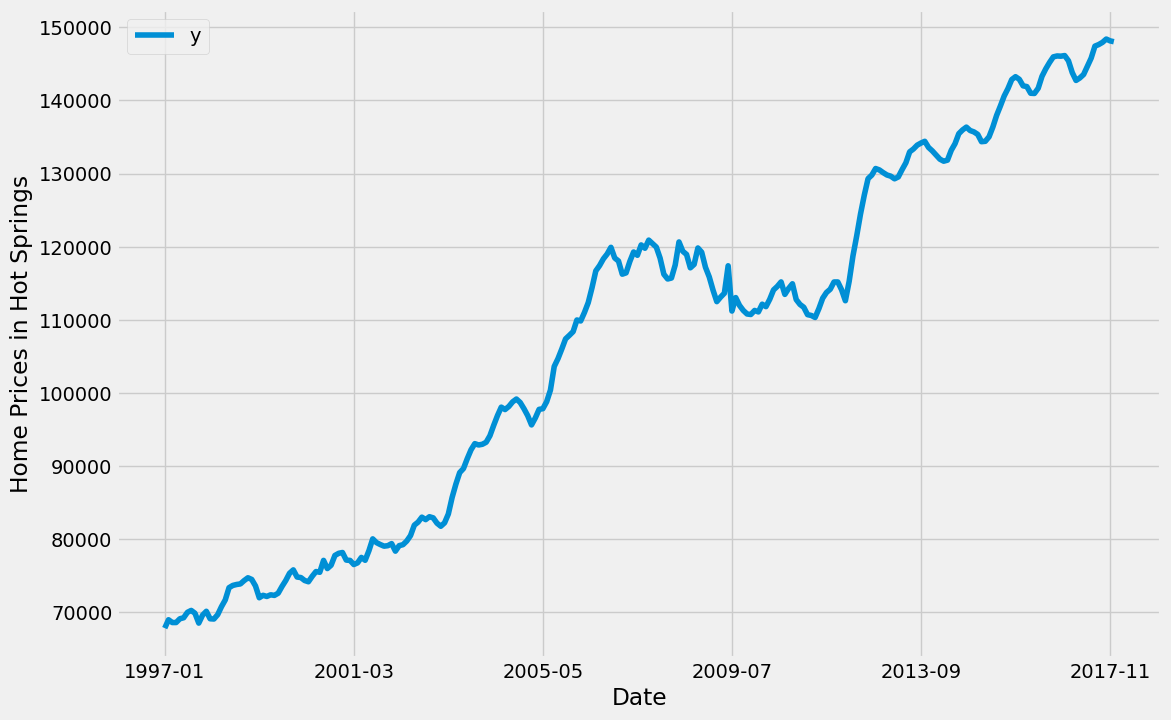

In [16]:
graph_prices_for(hs, "Hot Springs")

#### Prices for Little Rock, AR

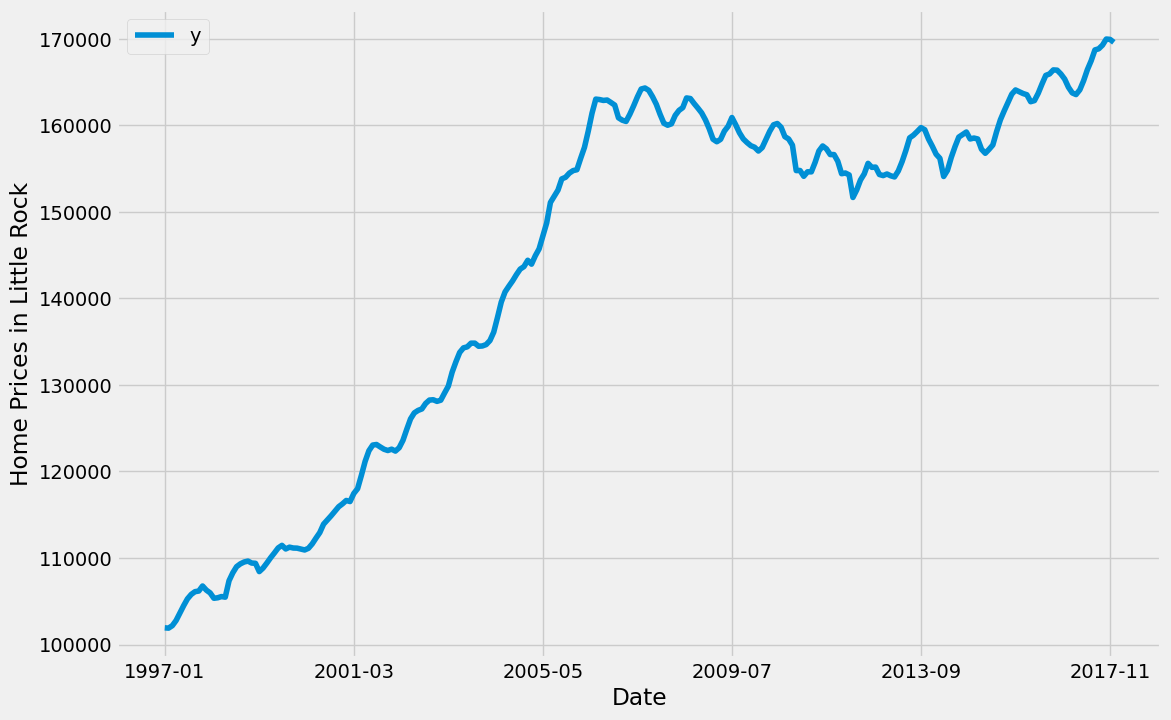

In [17]:
graph_prices_for(lr, "Little Rock")

#### Prices for Fayetteville, AR

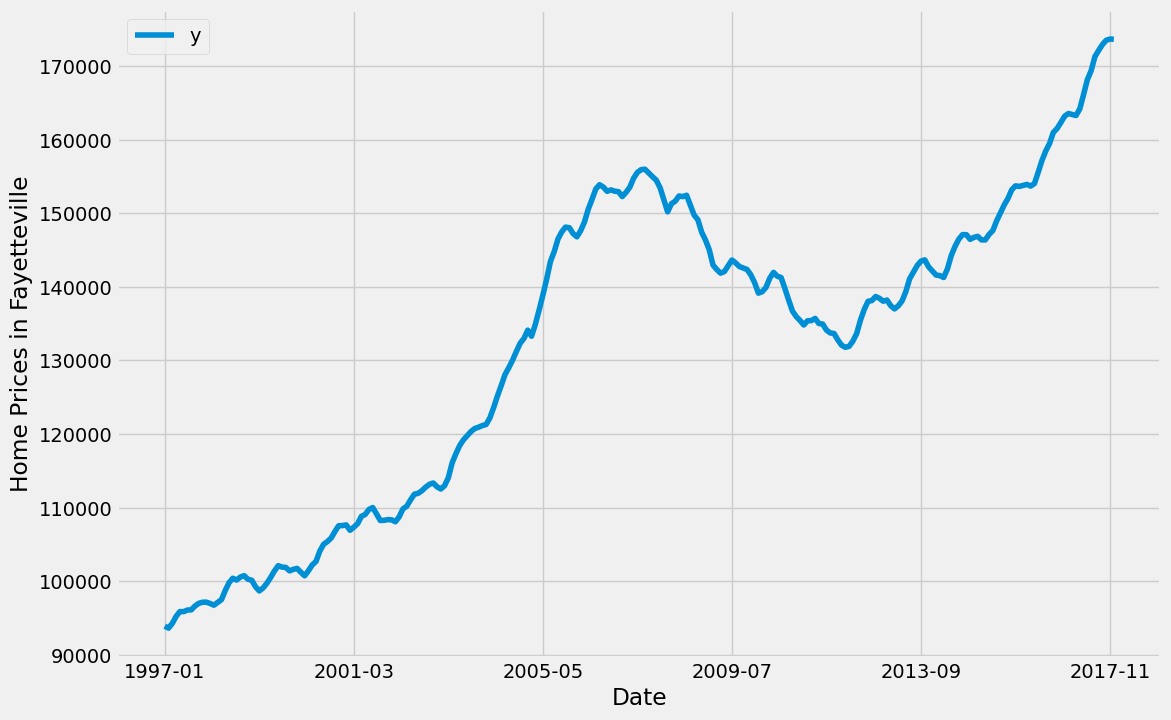

In [18]:
graph_prices_for(f, "Fayetteville")

#### Prices for Searcy, AR

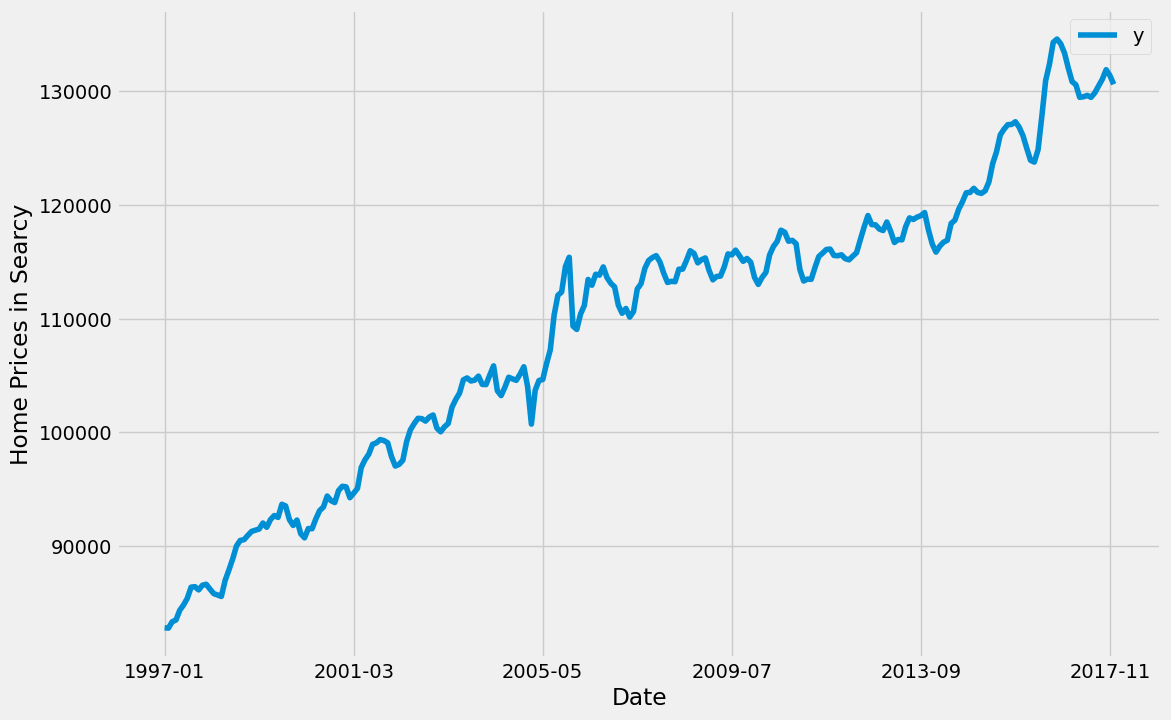

In [19]:
graph_prices_for(s, "Searcy")

#### Merge the Smaller DFs to create a plot with all of the specified cities

In [20]:
def transform(df, location_name):
    df_t = df.loc[:, '1997-01'::].T
    df_t['avg'] = df_t.mean(numeric_only=True, axis=1)
    df_t.reset_index(inplace=True)
    columns = ['index', 'avg']
    df = pd.DataFrame(df_t, columns = columns)
    df['place'] = location_name
    return df

In [21]:
hs_t = transform(hs, 'Hot Springs')
lr_t = transform(lr, 'Little Rock')
f_t = transform(f, 'Fayetteville')
s_t = transform(s, 'Searcy')

In [22]:
big_df = hs_t.append([lr_t,f_t,s_t])

<ipython-input-22-8d6b177befdb>:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [23]:
big_df['year'] = big_df.apply(lambda x: x['index'].split('-')[0], axis=1)
big_df['month'] = big_df.apply(lambda x: x['index'].split('-')[1], axis=1)
big_df['day'] = '01'
big_df['Date'] = pd.to_datetime(big_df[['year','month','day']])

In [24]:
by_place = pd.DataFrame(big_df.groupby(['place','year'])['avg'].mean())
by_place.reset_index(inplace=True)

#### Time Series Plot for Average Home Values by Year in Arkansas

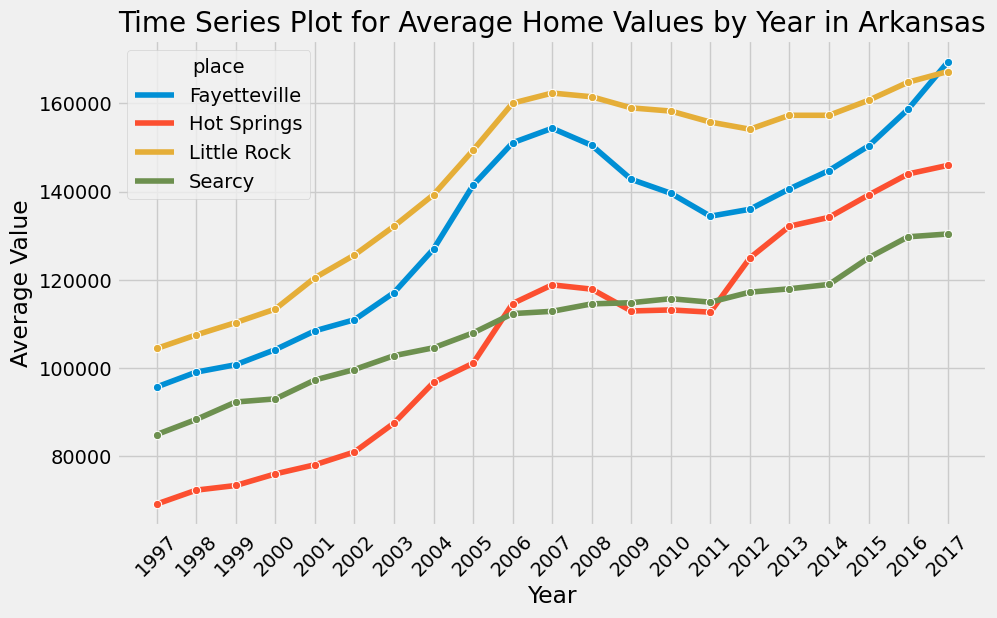

In [25]:
# Create a time series line plot using Seaborn with rotated x-axis labels
plt.figure(figsize=(10, 6))
sns.lineplot(data=by_place, x='year', y='avg', hue='place', marker='o')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees

plt.title('Time Series Plot for Average Home Values by Year in Arkansas')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.show()

### Develop time series plots for the following Arizona metro areas:
#### Phoenix, Tucson, Yuma, Payson
#### Present all values from 1997 to present
#### Average at the metro area level

In [26]:
phx = filtered_df[filtered_df['Metro'].str.contains('phoenix', na=False)]
tucson = filtered_df[filtered_df['Metro'].str.contains('tucson', na=False)]
yuma = filtered_df[filtered_df['Metro'].str.contains('yuma', na=False)]
payson = filtered_df[filtered_df['Metro'].str.contains('payson', na=False)]

#### Prices for Phoenix, AZ

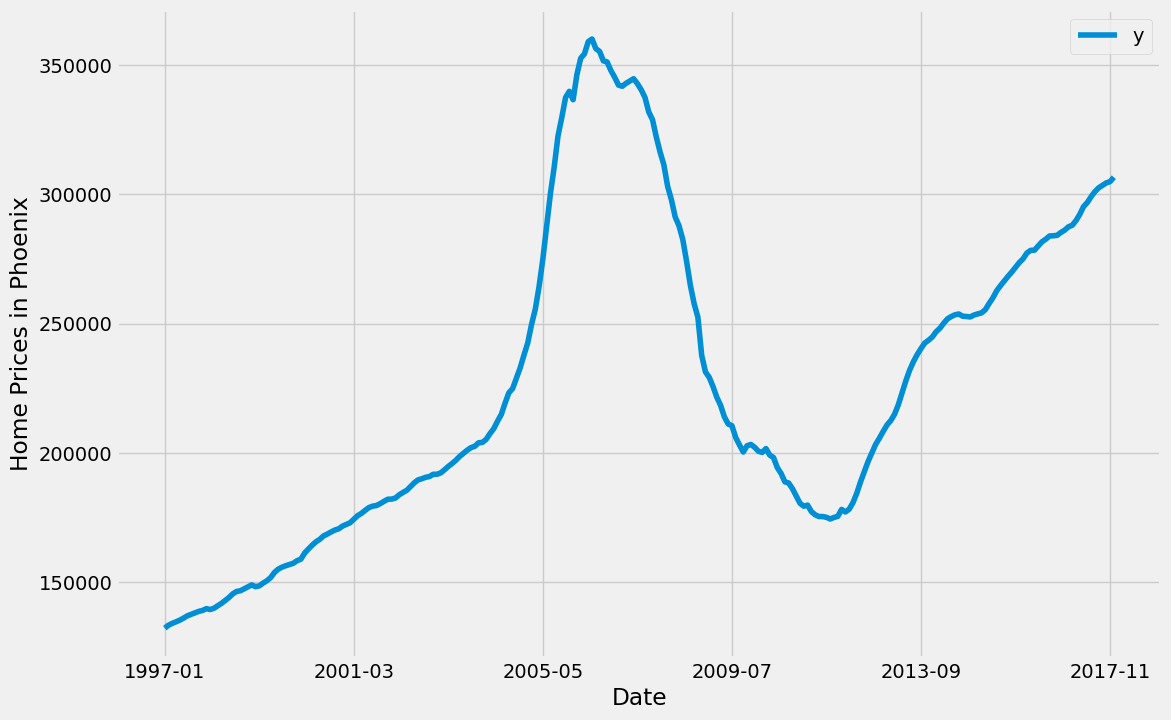

In [27]:
graph_prices_for(phx, "Phoenix")

#### Prices for Tucson, AZ

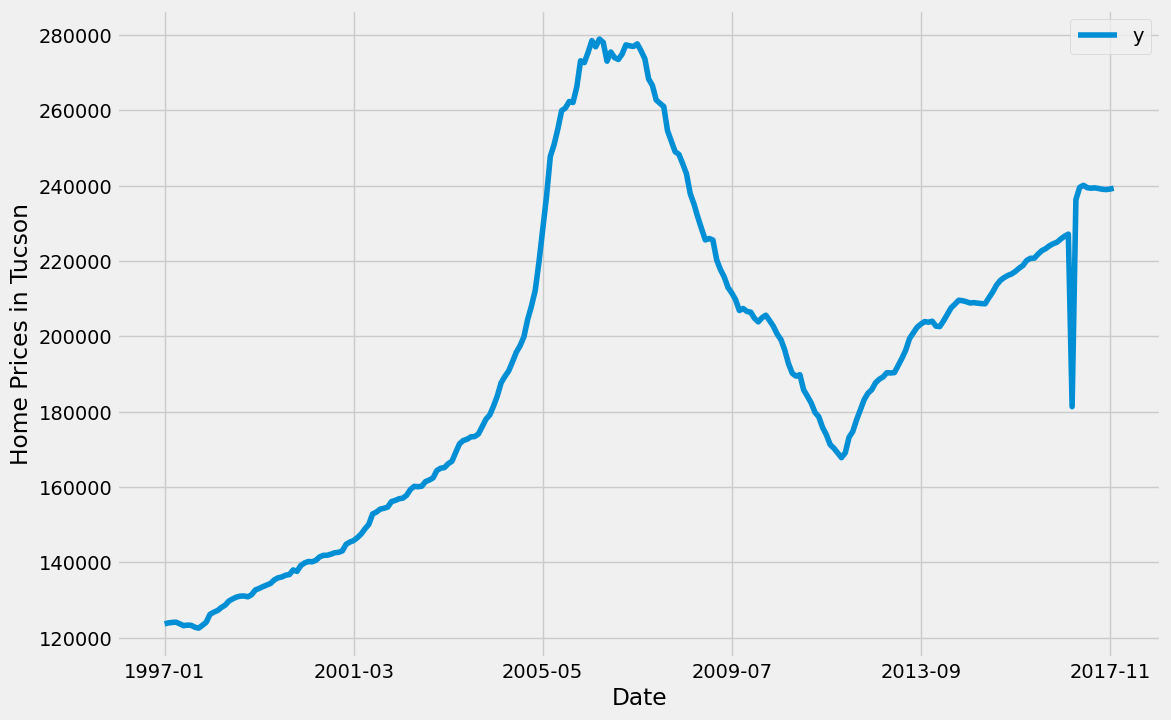

In [28]:
graph_prices_for(tucson, "Tucson")

#### Prices for Yuma, AZ

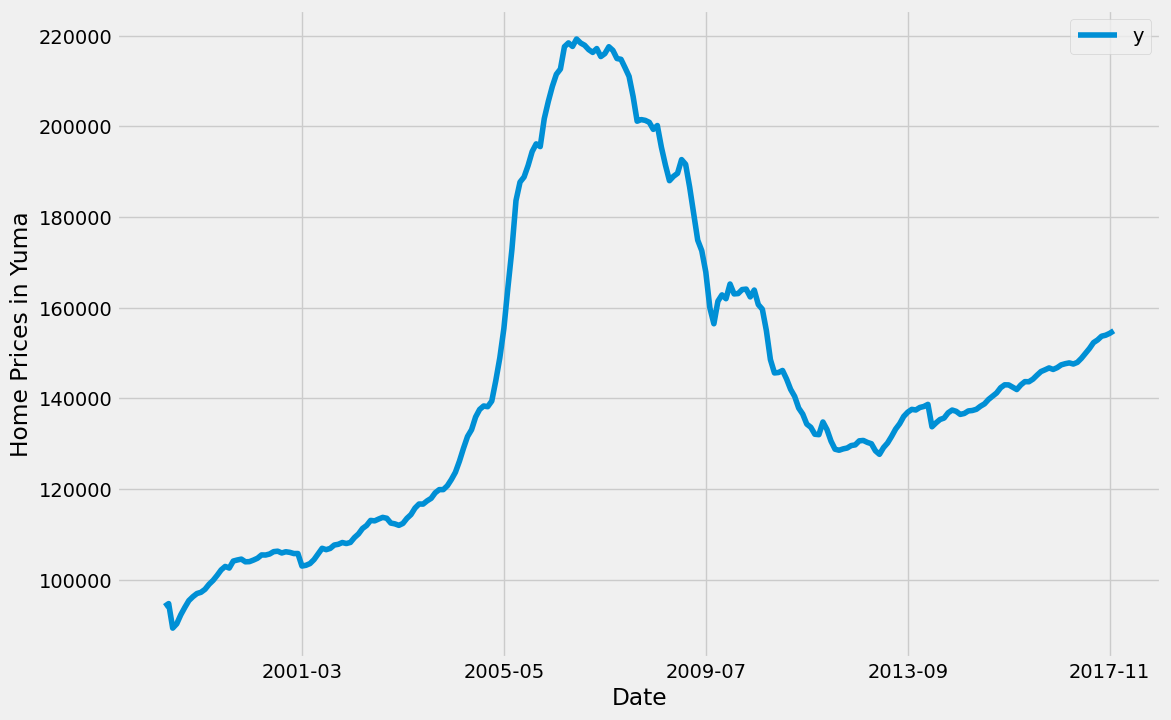

In [29]:
graph_prices_for(yuma, "Yuma")

#### Prices for Payson, AZ

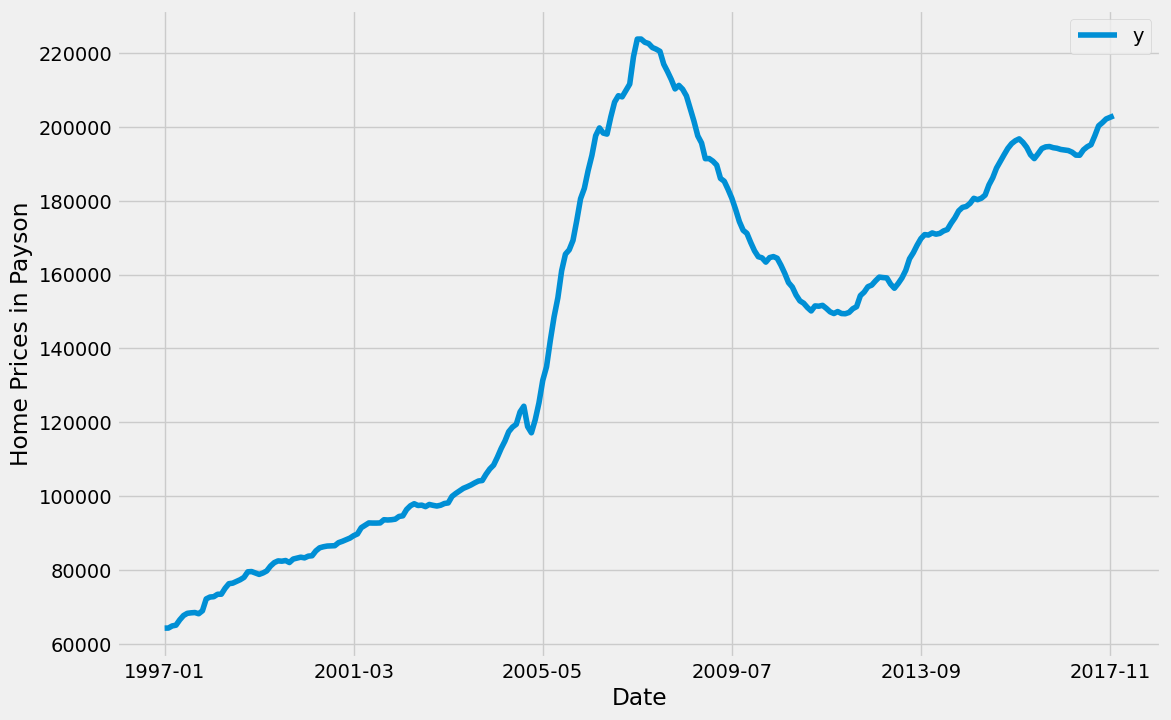

In [30]:
graph_prices_for(payson, "Payson")

In [31]:
phx_t = transform(phx, 'Phoenix')
tucson_t = transform(tucson, 'Tucson')
yuma_t = transform(yuma, 'Yuma')
payson_t = transform(payson, 'Payson')

In [32]:
big_df2 = phx_t.append([tucson_t,yuma_t,payson_t])

<ipython-input-32-c75f3c38c7bd>:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [33]:
big_df2['year'] = big_df2.apply(lambda x: x['index'].split('-')[0], axis=1)
big_df2['month'] = big_df2.apply(lambda x: x['index'].split('-')[1], axis=1)
big_df2['day'] = '01'
big_df2['Date'] = pd.to_datetime(big_df2[['year','month','day']])

In [34]:
by_place2 = pd.DataFrame(big_df2.groupby(['place','year'])['avg'].mean())
by_place2.reset_index(inplace=True)

#### Time Series Plot for Average Home Values by Year in Arizona

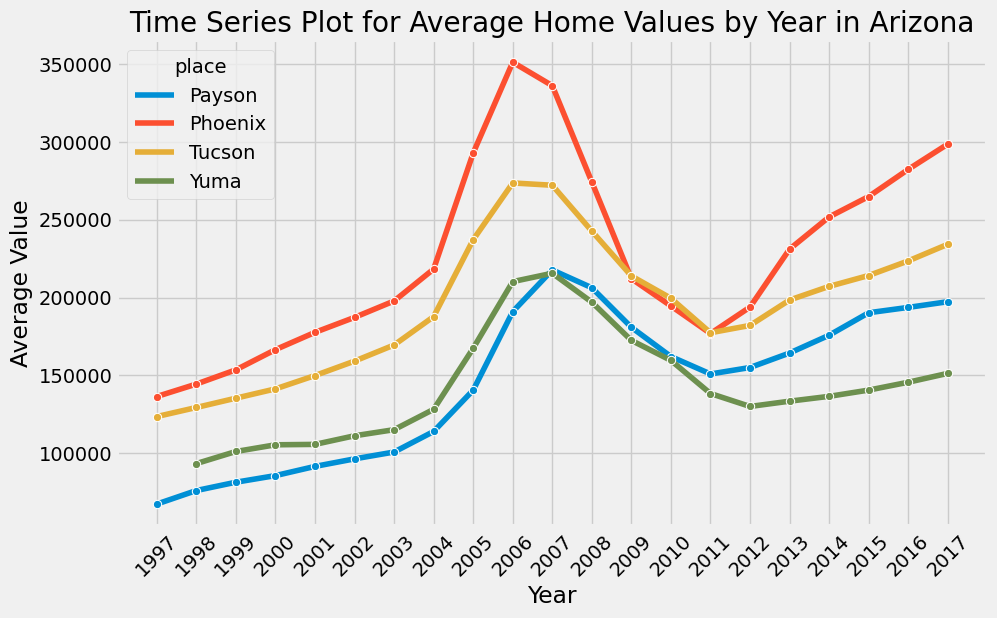

In [35]:
# Create a time series line plot using Seaborn with rotated x-axis labels
plt.figure(figsize=(10, 6))
sns.lineplot(data=by_place2, x='year', y='avg', hue='place', marker='o')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees

plt.title('Time Series Plot for Average Home Values by Year in Arizona')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.show()

### Can we predict which three zip codes provide the best investment opportunity?

In [36]:
filtered_df.head(1)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1997-01,...,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
0,91982,1,77494,zip,TX,tx,katy,"houston-the woodlands-sugar land, tx",fort bend county,180715.917877,...,332680.115296,335709.575946,337400.117579,338669.424322,339702.688759,339727.221576,338324.366192,337767.450148,336210.189381,335704.482543


Now we need to build a prediction model to figure out which zip codes Syracuse Real Estate Investment Trust (SREIT) should invest in.

In [37]:
# Import the zillow data
data = pd.read_csv('Zip_zhvi_uc_sfr_month.csv').fillna(0)

# convert non-timeseries
data[['City', 'State', 'Metro', 'CountyName']] = data[['City', 'State', 'Metro', 'CountyName']].astype(str)
data[['RegionID', 'RegionName', 'SizeRank']] = data[['RegionID', 'RegionName', 'SizeRank']].astype(int)

# convert to lowercase
data[['City', 'State', 'Metro', 'CountyName']] = data[['City', 'State', 'Metro', 'CountyName']].apply(lambda x: x.astype(str).str.lower().map(lambda x: x.strip()))
data['RegionName'] = data['RegionName'].astype('str').apply(lambda x: x.zfill(5))


In [38]:
date_columns = data.columns[9:]

# Extract and format the year and month in the "YYYY-MM" format for column names
formatted_column_names = date_columns.str.slice(0, 7)

# Rename the columns with the formatted names
data.columns = data.columns[:9].tolist() + formatted_column_names.tolist()

In [39]:
# timeseries data
ts_start = data.columns.get_loc('1996-04') + 1
ts_end = data.columns.get_loc('2017-09')
date_columns = data.iloc[:, ts_start:ts_end].columns.tolist()

# ensure integer timeseries
data[date_columns] = data[date_columns].astype(int)

In [40]:
# train: collapse column by median
train_start = data.columns.get_loc('1997-01')
train_stop = data.columns.get_loc('2017-01')
test_stop = data.columns.get_loc('2017-09')
train_columns = data.iloc[:, train_start:train_stop].columns.tolist()
test_columns = data.iloc[:, (train_stop + 1):test_stop].columns.tolist()

In [41]:
# remove rows with 0's beginning (1997-01) with trainset
date_columns = data.iloc[:, train_start:test_stop].columns.tolist()

data[date_columns] = data[date_columns].replace(0, np.nan)
data[date_columns] = data[date_columns].dropna()

In [42]:
# Creating training and testing datasets
df_train = data[train_columns].median().T
df_test = data[test_columns].median().T

In [43]:
dft = pd.DataFrame(df_train)

In [44]:
dft.index

Index(['1997-01', '1997-02', '1997-03', '1997-04', '1997-05', '1997-06',
       '1997-07', '1997-08', '1997-09', '1997-10',
       ...
       '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08',
       '2016-09', '2016-10', '2016-11', '2016-12'],
      dtype='object', length=240)

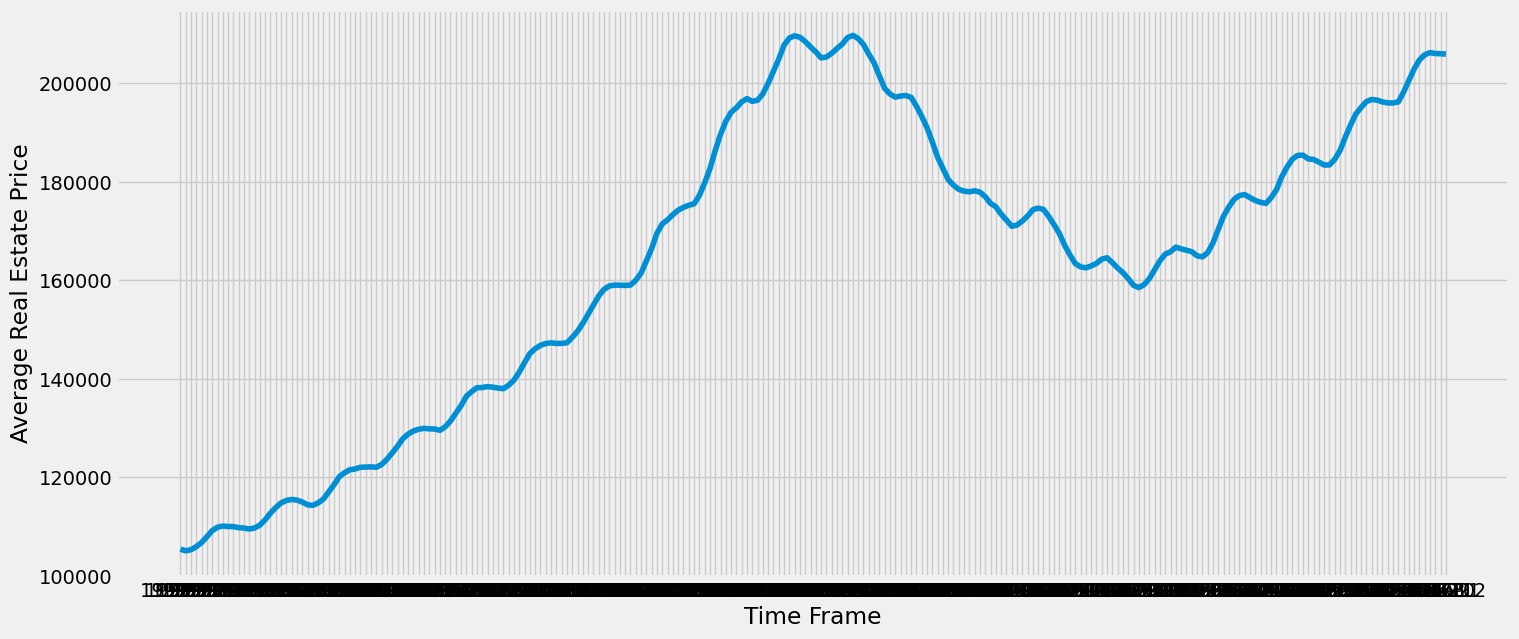

In [45]:
#Plotting the training dataset timeseries
plt.figure(figsize=(16,7))
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Time Frame')
ax1.set_ylabel('Average Real Estate Price')
ax1.plot(dft)

In [39]:
dft["diff"] = dft[0] - dft[0].shift(1)

In [40]:
dft.head(5)

,0,diff
1997-01,116142.0,NaN
1997-02,115771.5,-370.5
1997-03,116351.0,579.5
1997-04,117063.0,712.0
1997-05,118078.5,1015.5


<Axes: title={'center': 'Making the Time Series Stationary - Differencing'}>

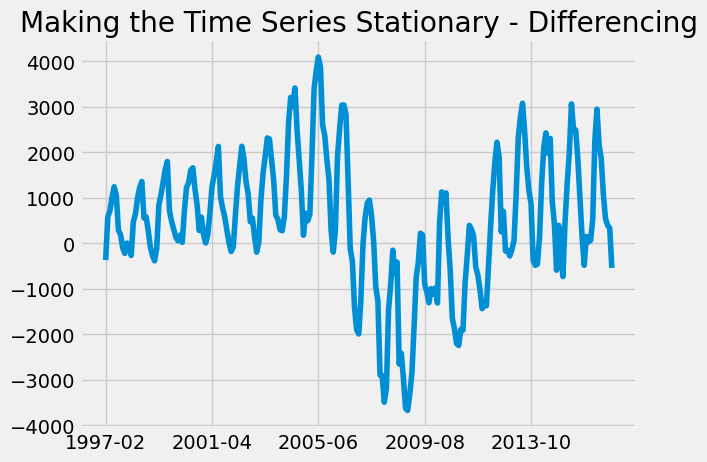

In [41]:
plt.title("Making the Time Series Stationary - Differencing")
dft["diff"].dropna().plot()

In [42]:
# Calculate the log
dft['adj_log'] = np.log(dft[0])

<Axes: >

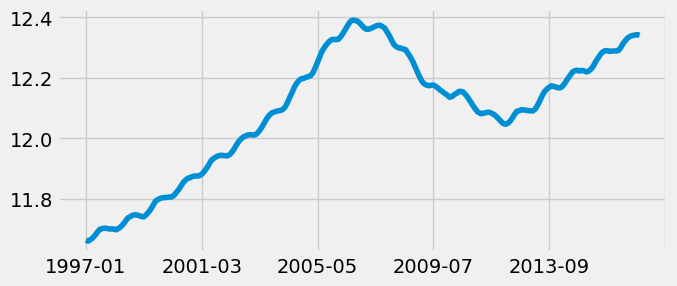

In [43]:
plt.figure(figsize=(7,3))
dft["adj_log"].dropna().plot()

<Axes: >

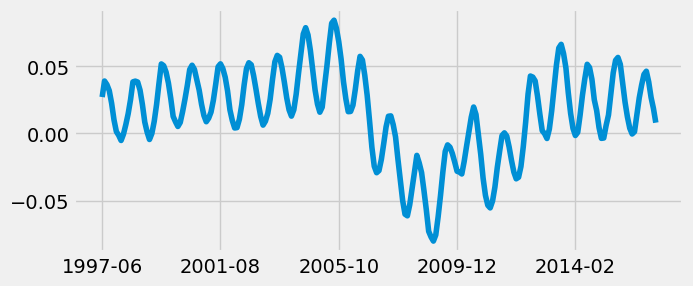

In [44]:
plt.figure(figsize=(7,3))
dft['log_diff'] = dft['adj_log'] - dft['adj_log'].shift(5)
dft['log_diff'].dropna().plot()

<Axes: >

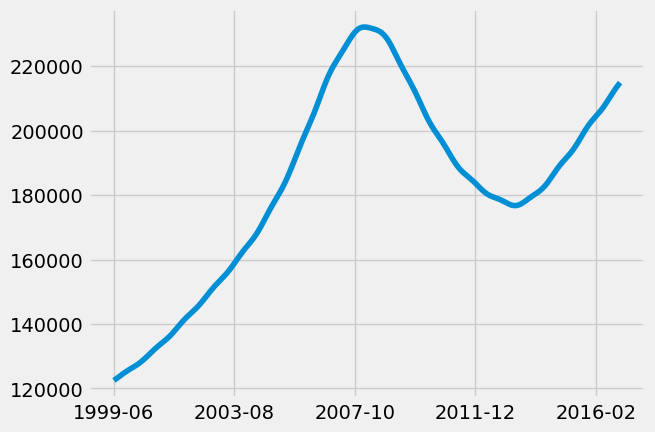

In [45]:
# Rolling Statistics
dft['#MA20'] = dft[0].rolling(window = 30).mean()
dft['#MA20'].dropna().plot()

In [46]:
dft=dft.reset_index()
dft.head(5)

,index,0,diff,adj_log,log_diff,#MA20
0,1997-01,116142.0,NaN,11.662569,NaN,NaN
1,1997-02,115771.5,-370.5,11.659374,NaN,NaN
2,1997-03,116351.0,579.5,11.664367,NaN,NaN
3,1997-04,117063.0,712.0,11.670468,NaN,NaN
4,1997-05,118078.5,1015.5,11.679105,NaN,NaN


In [47]:
dft['index'] = pd.to_datetime(dft['index'], yearfirst = True)
dft.head()

,index,0,diff,adj_log,log_diff,#MA20
0,1997-01-01,116142.0,NaN,11.662569,NaN,NaN
1,1997-02-01,115771.5,-370.5,11.659374,NaN,NaN
2,1997-03-01,116351.0,579.5,11.664367,NaN,NaN
3,1997-04-01,117063.0,712.0,11.670468,NaN,NaN
4,1997-05-01,118078.5,1015.5,11.679105,NaN,NaN


In [48]:
dft = dft.set_index('index')

Text(0.5, 0.98, '\nMultiplicative Decompose')

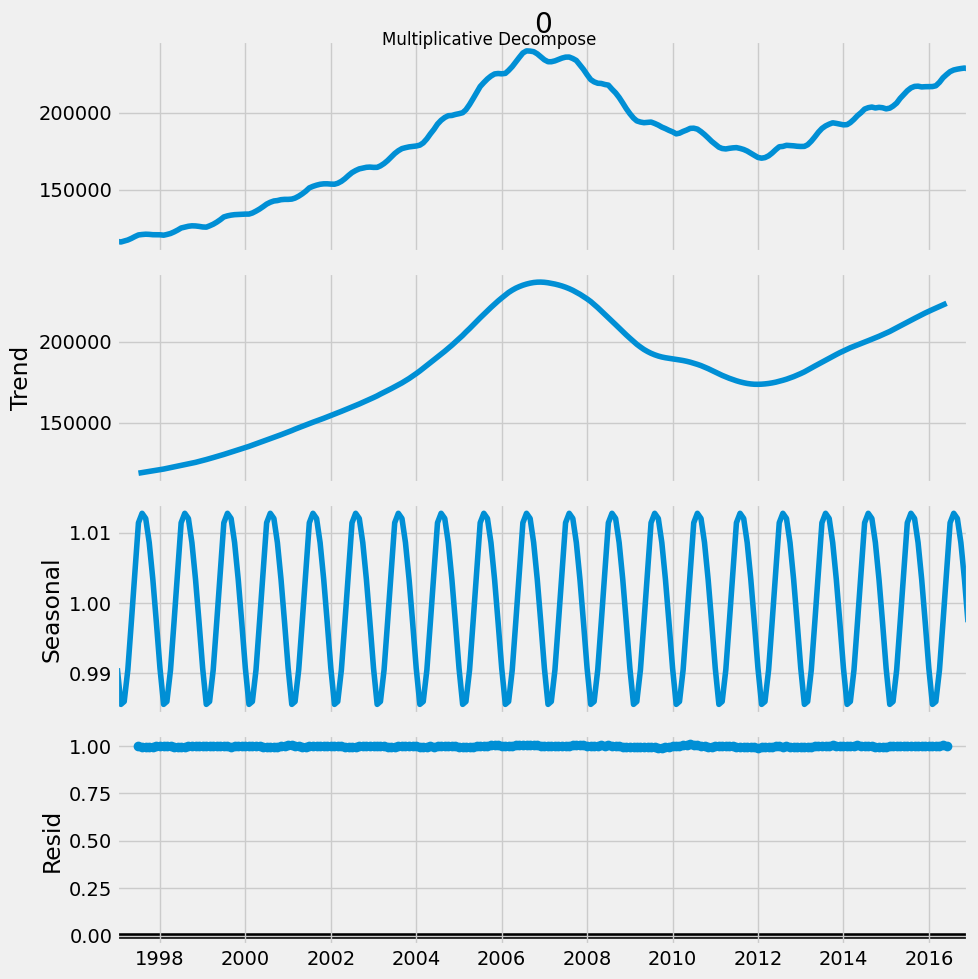

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Multiplicative Decomposition
mul_result = seasonal_decompose(dft[0], model='multiplicative')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
mul_result.plot().suptitle('\nMultiplicative Decompose', fontsize=12)

In [46]:
# ADF Test - nul hypothesis - non-stationary - if p-value < 5% reject null hypothesis
adfuller_result = adfuller(dft[0].values, autolag='AIC')

print(f'ADF Statistic: {adfuller_result[0]}')

print(f'p-value: {adfuller_result[1]}')

for key, value in adfuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.6145120001442212
p-value: 0.47560759267996355
Critial Values:
   1%, -3.459884913337196
Critial Values:
   5%, -2.8745310704320794
Critial Values:
   10%, -2.573693840082908


In [51]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_train, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  240
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2074.511
Date:                Wed, 08 Nov 2023   AIC                           4161.022
Time:                        16:26:27   BIC                           4181.881
Sample:                    01-01-1997   HQIC                          4169.428
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0548      0.005     10.333      0.000       0.044       0.065
ar.L2          0.0522      0.007      7.006      0.000       0.038       0.067
ar.L3          0.0349      0.013      2.717      0.0

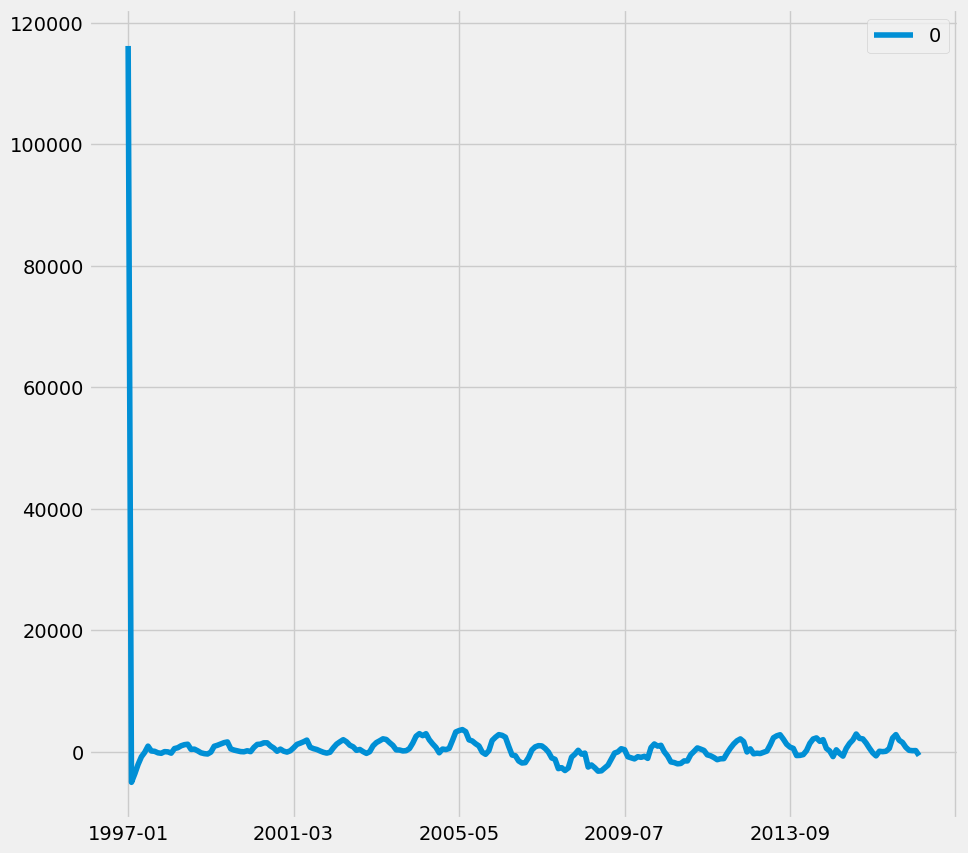

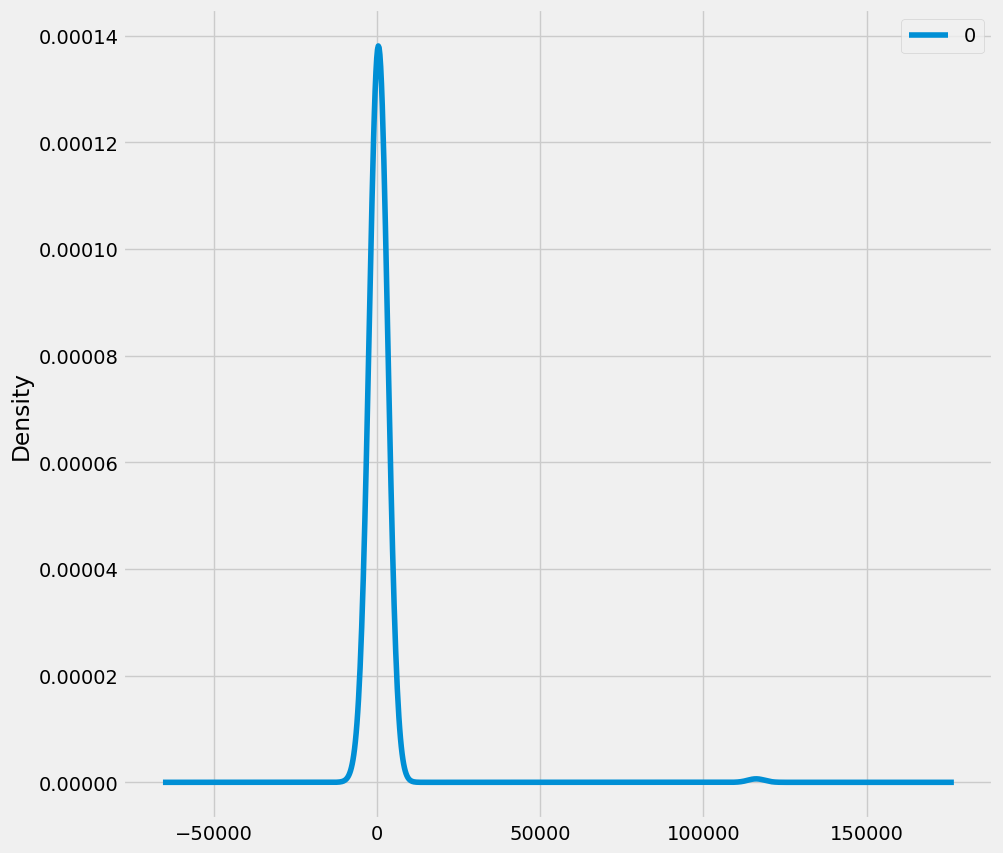

                   0
count     240.000000
mean      806.001459
std      7603.264160
min     -5061.689455
25%      -316.161061
50%       281.804295
75%      1249.330592
max    116142.000000


In [52]:
# plot residual errors
def residuals_plot(model_fit):
    residuals = DataFrame(model_fit.resid)
    residuals.plot()
    plt.show()

    # plot kernel density estimation
    residuals.plot(kind='kde')
    plt.show()

    # descriptibe statistics
    print(residuals.describe())

residuals_plot(model_fit)

In [53]:
#
# rolling prediction (verify model): month +2, since the train
#     includes 2017-01.
#
# Note: rolling prediction is required since there is an implicit
#       dependence on observations in prior time steps inheritted
#       when autogressive (AR) model was defined.
#
history = [x for x in df_train]
predictions = list()
iterations = (12-len(df_test)) + 18

for t in range(iterations):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)

    if t > 10:
        year = 2018
        month = (t+2) % 12
        if month == 0:
            month = 12
    else:
        year = 2017
        month = t+2
        if month == 0:
            month = 12

    print('\n===============================================')
    print('date: {}-{:01d}'.format(year, month))
    print('-----------------------------------------------')

    #
    # observation: if current value doesn't exist from test, append current
    #     predition, to ensure successive rolling prediction computed.
    #
    try:
        obs = df_test[t]
        print('predicted={:03f}, expected={:03f}'.format(float(yhat), obs))
        print('prediction difference: {:03f}'.format(abs(1-float(yhat)/obs)))
        print('\n===============================================')
        error = mean_squared_error(df_test, predictions)
        print('Test MSE: {:03f}\n\n'.format(error))
    except:
        obs = yhat
        print('predicted={:03f}'.format(float(yhat)))

    history.append(obs)


date: 2017-2
-----------------------------------------------
predicted=228763.764678, expected=229166.000000
prediction difference: 0.001755

predicted=228763.764678

date: 2017-3
-----------------------------------------------
predicted=228766.811286, expected=231049.000000
prediction difference: 0.009878

predicted=228766.811286

date: 2017-4
-----------------------------------------------
predicted=228763.827405, expected=233653.000000
prediction difference: 0.020925

predicted=228763.827405

date: 2017-5
-----------------------------------------------
predicted=228757.872938, expected=236777.000000
prediction difference: 0.033868

predicted=228757.872938

date: 2017-6
-----------------------------------------------
predicted=228749.198162, expected=239648.000000
prediction difference: 0.045478

predicted=228749.198162

date: 2017-7
-----------------------------------------------
predicted=228748.896804, expected=242425.000000
prediction difference: 0.056414

predicted=228748.89680

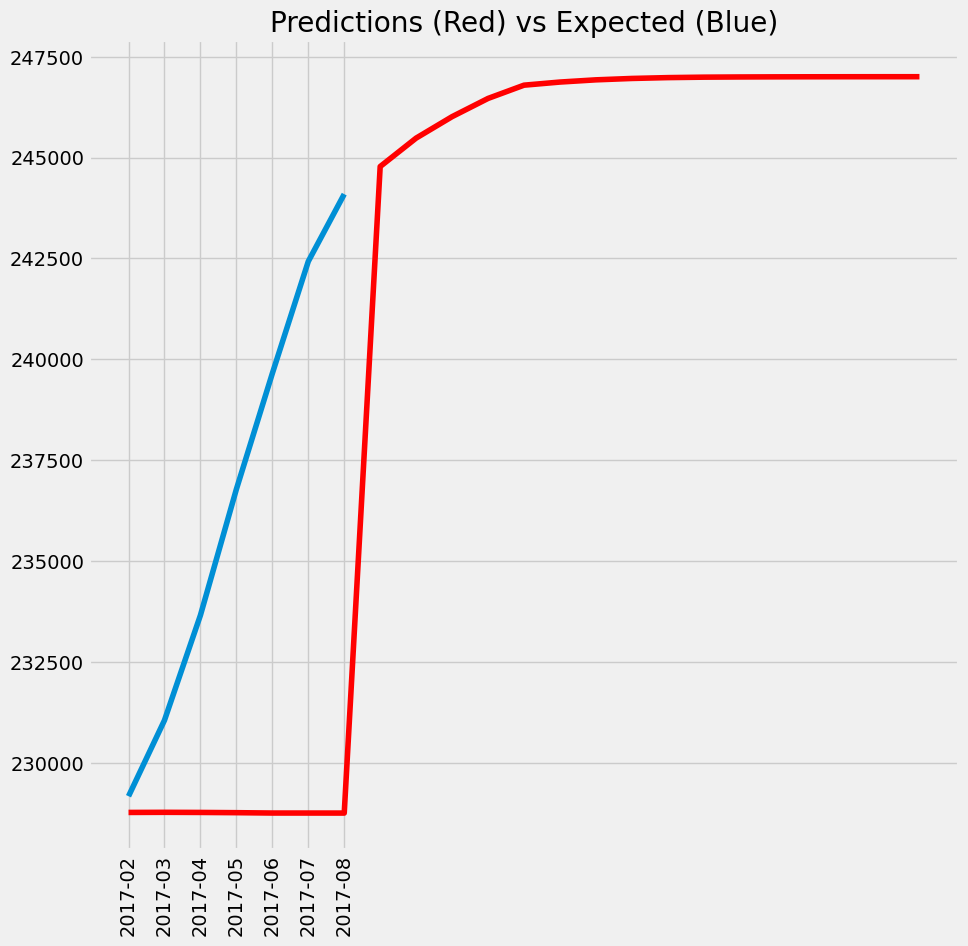

In [54]:
# plot rolling prediction
def rolling_plot(data, predictions):
    plt.plot(predictions, color='red')
    plt.plot(data)
    plt.xticks(rotation=90)
    plt.title('Predictions (Red) vs Expected (Blue)')
    plt.show()

rolling_plot(df_test, predictions)

In [55]:
# stationarity test
def difference(dataset, interval):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def compute_arima(
    data=df_train,
    p=5,
    q=0,
    d=0,
    delta=(12-len(df_test)) + 18,
    alpha=0.05,
    rplot=False,
    summary=False
):
    #
    # Note: rolling prediction is required since there is an implicit
    #       dependence on observations in prior time steps inheritted
    #       when autogressive (AR) model was defined.
    #
    history = [x for x in data]
    predictions = list()
    model_fit = False

    # generate model
    try:
        model = ARIMA(difference(history, delta), order=(p,q,d))
        model_fit = model.fit()
        print('standard fit used')
    except Exception as e:
        print('stationary differences will be used')
        print('original error: {}'.format(e))

    # significant stationarity: use any that works
    if not model_fit:
        #
        # determine stationarity value: differencing handled with supplied data,
        #     as an indirect solution, since statsmodel not allow d > 2.
        #
        # @delta, autoregressive factor.
        #
        for delta in range(10):
            stationary = difference(history, delta)
            stationary.index = history[1:]
            result = adfuller(stationary)
            print('stationary fit: {}, p: {}'.format(delta, result[1]))

            #
            # generate model: use high (10) autoregression, since data is not
            #     seasonal. Therefore, using previous values is conservative.
            #
            if (result[1] <= 0.05):
                try:
                    model = ARIMA(stationary, order=(p,q,d))
                    model_fit = model.fit(disp=0)
                    break
                except Exception as e:
                    print('bad condition {}: stationarity not adequate'.format(delta))
                    print('original error: {}'.format(e))
                    continue

    #
    # generate forecast: an inverse difference is needed to reverse the earlier
    #     difference model scaling.
    #
    if model_fit:
        output = model_fit.forecast(steps=delta, alpha=alpha)[0]
        if rplot:
            residuals_plot(model_fit)
        if summary:
            print(model_fit.summary())

    for yhat in output:
        inverted = inverse_difference(history, yhat, interval=delta)
        history.append(inverted)
        predictions.append(inverted)

    print('predictions: {}'.format(predictions))

    return(predictions)

In [56]:
df_zipcode_clean = data.drop([
    'RegionID',
    'SizeRank',
    'RegionType',
    'StateName',
    'State',
    'City',
    'Metro',
    'CountyName'
], axis=1)

In [57]:
# group by zipcode
df_zipcode_clean_transform = df_zipcode_clean.groupby('RegionName').agg(np.median).dropna().T

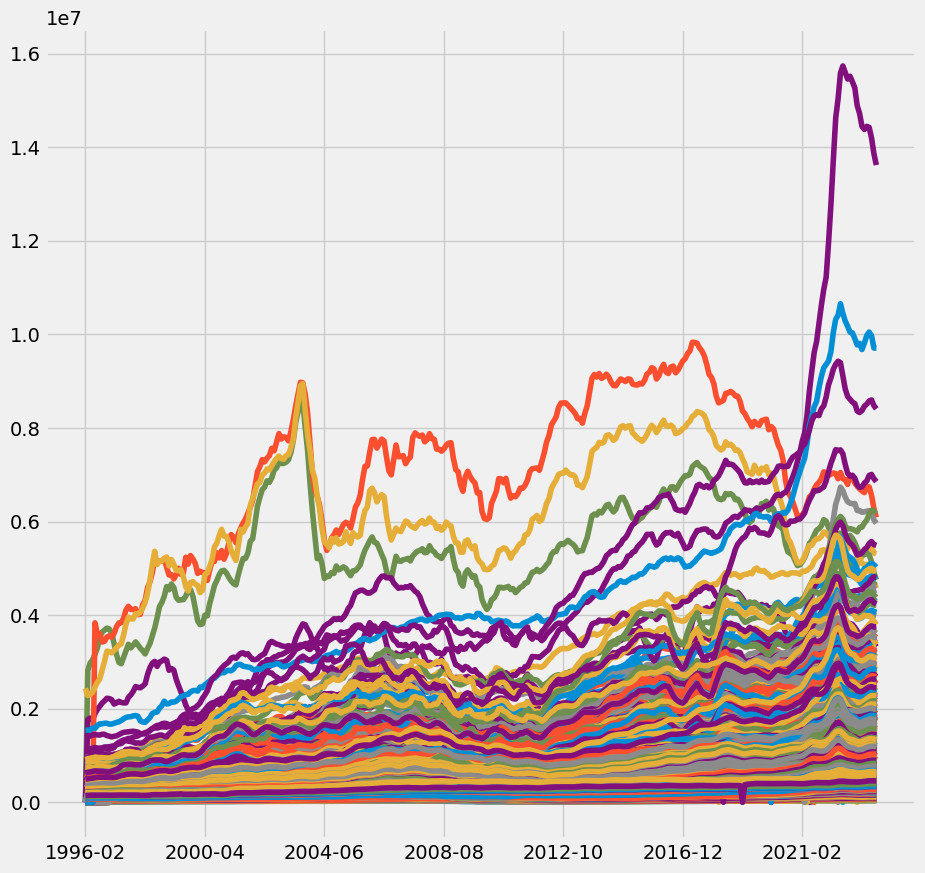

In [58]:
df_zipcode_clean_transform.plot(legend=None)
plt.show()

In [59]:
df_zipcode_clean_transform.head()

RegionName,01001,01002,01005,01007,01010,01013,01020,01027,01028,01030,...,99501,99502,99503,99504,99508,99515,99516,99517,99567,99577
1996-02,104974.920131,161278.252320,102082.073780,134328.710958,116085.071581,84163.365851,93336.413334,121650.268053,135955.137900,114955.122331,...,105493.861584,128120.779482,96133.689193,101073.003801,100981.380248,145106.223161,204208.174437,119981.356607,141245.477997,142936.429300
1996-03,106127.744030,162100.225017,102823.391713,134794.065414,116763.402798,85256.989675,94042.807369,122719.569606,137166.478715,116054.606068,...,107441.104038,128576.379528,97506.219948,104584.714225,103056.215616,144092.562766,202650.979261,120569.497763,145988.954942,148123.151552
1996-04,106875.427131,163794.827891,104221.615931,136318.723093,117175.808515,85094.884405,94659.556202,124080.571690,137313.132520,116718.014293,...,108050.739539,129343.587321,97493.428908,105910.229500,103587.710525,145485.609651,205960.264765,121453.540583,150766.668346,152194.290904
1996-05,106687.000000,165157.000000,105047.000000,137970.000000,117780.000000,85602.000000,95072.000000,125482.000000,136624.000000,116587.000000,...,108840.000000,130363.000000,98214.000000,107476.000000,104112.000000,145211.000000,205691.000000,122258.000000,152478.000000,152495.000000
1996-06,108186.000000,166862.000000,107471.000000,139027.000000,118526.000000,87629.000000,96688.000000,126448.000000,136993.000000,118532.000000,...,109767.000000,132189.000000,100118.000000,107936.000000,105546.000000,146312.000000,207104.000000,123661.000000,152313.000000,152721.000000


In [60]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Prepare the data
train_data = df_zipcode_clean_transform['1996-01':'2017-12']
test_data = df_zipcode_clean_transform['2018-01':'2018-12']

# Create a list of zip codes to analyze
zip_codes = df_zipcode_clean_transform.columns

best_zip_codes = {}  # To store the metric (e.g., MSE) for each zip code

for zip_code in zip_codes:
    # Prepare training and testing data for the current zip code
    train_series = train_data[zip_code]
    test_series = test_data[zip_code]

    # Feature Engineering (Example: Use lag values as features)
    train_features = train_series.shift(1)  # Use lag of 1 as a feature
    train_features = train_features.dropna()  # Remove NaN values
    train_target = train_series[1:]  # Target variable without the first value

    # Train a Random Forest Regressor model
    model = RandomForestRegressor(n_estimators=100, random_state=42)  # Adjust parameters as needed
    model.fit(train_features.values.reshape(-1, 1), train_target)

    # Make predictions for 2018
    test_features = test_series.shift(1)  # Use lag of 1 as a feature
    test_features = test_features.dropna()
    predictions = model.predict(test_features.values.reshape(-1, 1))

    # Calculate the Mean Squared Error for the zip code
    mse = mean_squared_error(test_series[1:], predictions)
    best_zip_codes[zip_code] = mse

# Rank the zip codes based on the metric (lower is better)
top_zip_codes = sorted(best_zip_codes, key=best_zip_codes.get)

# Get the top zip codes for investment opportunities in 2018
top_zip_codes_2018 = top_zip_codes[:3]

print("Top three zip codes for investment opportunities in 2018:", top_zip_codes_2018)


KeyboardInterrupt: ignored

1.   44502 - Youngstown, OH
2.   74401 - Muskogee, OK
3.   72335 - Forrest City, AR


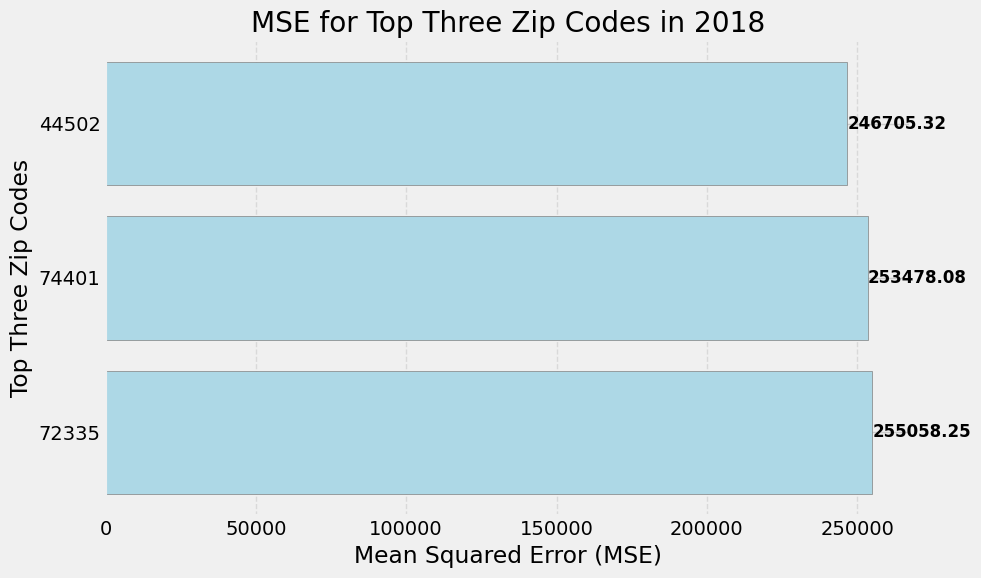

In [ ]:
import matplotlib.pyplot as plt

# Sort the zip codes by MSE (lower MSE is better)
sorted_zip_codes = sorted(best_zip_codes.items(), key=lambda x: x[1])

# Extract the top three zip codes
top_three_zip_codes = sorted_zip_codes[:3]

# Separate the zip codes and MSE values
zip_code_names, mse_values = zip(*top_three_zip_codes)

# Create a visually appealing bar plot
plt.figure(figsize=(10, 6))
plt.barh(zip_code_names, mse_values, color='lightblue', edgecolor='grey')  # Use horizontal bar plot
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Top Three Zip Codes')
plt.title('MSE for Top Three Zip Codes in 2018')
plt.grid(axis='x', linestyle='--', alpha=0.6)  # Add grid lines
plt.gca().invert_yaxis()  # Invert the y-axis for readability

# Annotate the bars with their MSE values
for i, v in enumerate(mse_values):
    plt.text(v, i, f'{v:.2f}', color='black', va='center', fontsize=12, fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()
